# Analyzing Impact of Live Demo Classes on Sales Conversion 

Here we will be analyzing Demo Class Data and Subscription Data to deduce sales conversion based on various factors.

Description of Dataset: 

1. **Interested Users –** Users (child) who have shown interest in joining the demo classes.

2. **Booked Users –** Users who booked a trail class on our portal. There are cases where
duplicate trails are possible, count both.

3. **Trainers –** Trainers assigned to Trail Batch.

4. **Subscription Bought –** Details of Sales that are made. Use only those cases where sale
value is greater than equal to 499/-.

**Sales conversion** refers to the number of users who have bought the session after showing
interest and attending the trial session.

Assumptions:

1. We are taking into account the duplicate data into account from Booked Users.

2. We are taking into account only subscription worth Rs. 499 and above.

3. We will only take into consider those subscribed students who has both showed interest and attended the demo class as per the definition of sales conversion. If a student has just shown interest but not attended demo classes or attended demo classes without showing interest we will not consider them.

**Problems to be Answered:**

1. Sales conversion wrt grade
2. Time slot – attendance %
3. Sales conversion with respect to Time slot
4. Time taken for Sales conversion
5. Sales conversion with respect to Source (Field available in Interested Users)


# Sales Conversion wrt Grade

In [ ]:
# Reading the excel file and printing the sheet names
import pandas as pd
df1=pd.ExcelFile('assignment_data.xlsx')
df1.sheet_names

['Interested Users', 'Booked Users', 'Trainers', 'Subscription Bought']

In [ ]:
# Importing the Interested Users sheet as dataframe
interest=df1.parse(0)
interest.head()

,Child name,phone,email_id,school,grade,batch_preferred,source,Submitted At
0,CH_30001,911100221000,s2m_test_20001@tests2m.com,St.paul's school,Grade 2,"Afternoon Batch (4:00 - 4:45 PM), Evening Batc...",lastchance,2020-04-16 08:46:39
1,CH_30002,911100221001,s2m_test_20002@tests2m.com,K L E School haveri,Grade 4,"Evening Batch (6:15 - 7:00 PM), Morning Batch ...",lastchance,2020-04-16 08:47:55
2,CH_30003,911100221002,s2m_test_20003@tests2m.com,Delhu Public School Howrah,Grade 2,"Morning Batch (11:15 - 12:00 PM), Evening Batc...",lastchance,2020-04-16 08:47:59
3,CH_30004,911100221003,s2m_test_20004@tests2m.com,Bharathi vidya bhavans,Grade 2,"Evening Batch (6:15 - 7:00 PM), Afternoon Batc...",lastchance,2020-04-16 08:48:27
4,CH_30005,911100221004,s2m_test_20005@tests2m.com,Army public school Delhi cantt,Grade 4,"Evening Batch (6:15 - 7:00 PM), Afternoon Batc...",lastchance,2020-04-16 08:52:06


In [ ]:
# Renaming some columns
interest.rename(columns={'Child name':'Child Name','grade':'Grade'},inplace=True)

In [ ]:
# Importing the Booked Users sheet as dataframe
book=df1.parse(1)
book.head()

,Invitee UUID,Batch,Enrolment Type,Child Name,Grade,School,Phone,Parent Email,Opted Start Time,Opted Start Date,Facilitator UUID,Attendance
0,AGIV7AYTBF4ZA6SA,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,CH_31440,Grade 2,DPS,911100222445,s2m_test_21459@tests2m.com,16-04-2020 11:15:00,"11:15am - Thursday, April 16, 2020",AEFDOHX57EFVUS2G,Present
1,HAPQZDZXDJPMFZ73,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,CH_31441,Grade 2,DPS,911100222446,s2m_test_21460@tests2m.com,16-04-2020 11:15:00,"11:15am - Thursday, April 16, 2020",AEFDOHX57EFVUS2G,Present
2,AHLT5B5XGJTONPE3,"fREADom Trial Class - Grades 1, 2 [I] 11:15am ...",Trial,CH_31442,Grade 2,City Montessori school lucknow,911100222447,s2m_test_21461@tests2m.com,16-04-2020 11:15:00,"11:15am - Thursday, April 16, 2020",AEFDOHX57EFVUS2G,Absent
3,HCNR5B2SFMSX727O,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,CH_31443,Grade 4,Reliance Foundation,911100222448,s2m_test_21462@tests2m.com,16-04-2020 11:15:00,"11:15am - Thursday, April 16, 2020",CDBCIBX6WD5NGCEZ,Absent
4,BFIT2F3UDJ5MV5GT,"fREADom Trial - Grades 3, 4 [I] 11:15am - Thu...",Trial,CH_31444,Grade 3,KRS,911100222449,s2m_test_21463@tests2m.com,16-04-2020 11:15:00,"11:15am - Thursday, April 16, 2020",CDBCIBX6WD5NGCEZ,Present


'**Attendance**' column of book contain same value in different form. Eg: '**Attend**' is present in '**Present**', '**Attend**', '**Presnt**' and many other form. We need to convert/normalize them to one form else 
they will be considered as separate values.

Here we devided the values into two groups '**Attended**' and '**Not Attended**'. '**Attended**' included 'Present',
'Present ',
'present',
'Attended ',
'Preset',
':Present',
'Presnt',
'Present (Grade 8)',
'Duplicate',
'REPEAT NAME',
'Present logged in and out'.

 **Not Attended**' include 'Absent',
 'Cancelled',
 'absent',
 'Absent ',
 'Present with video and audio off'

Note that **Present logged in and out** is ambiguous. We place it in attended because when somebody logged in he/she may have attended most of the lecture and then disconnected because of some reason/emergency and liked the lecture and later bought the subscription.
So we don't want to miss out a subscriber so to be on the safe side we consider it in '**Attended**' category. 

Similarly we put '**Present with video and audio off**' in '**Not Attended**' category because without video or audio you cannot attend the lecture.

In [ ]:
book['Attendance']=book.Attendance.replace(['Present','Present ','present','Attended ','Preset',':Present','Presnt','Present (Grade 8)','Duplicate','REPEAT NAME','Present logged in and out'],['Attended']*11)
book['Attendance']=book.Attendance.replace(['Absent','Cancelled','absent','Absent ','Present with video and audio off'],['Not Attended']*5)
book.dropna(subset=['Attendance'],inplace=True)

In [ ]:
# Merging interest and book dataframe based on 'Child Name' column. Remember we will consider only those students who have shown interest and attended trial classes so we are performing
# inner join here.
mer=pd.merge(interest[['Child Name','Grade']],book[['Child Name','Grade','Attendance']],on=['Child Name','Grade'],how='inner')
mer.head()

,Child Name,Grade,Attendance
0,CH_30004,Grade 2,Attended
1,CH_30005,Grade 4,Not Attended
2,CH_30006,Grade 1,Not Attended
3,CH_30009,Grade 4,Attended
4,CH_30012,Grade 1,Not Attended


In [ ]:
# For calculating Sales Conversion we need to take into account those who attended the demo/trial classes.
mer=mer.query('Attendance=="Attended" ')

In [ ]:
# Importing Subscription Bought sheet as DataFrame.
sub=df1.parse(-1)
sub.head()

,Child Name,Registered Number,Registered Email ID,Payment date,Sale by,Grade,Pricing,Duration,Sessions preferred,Live session details
0,CH_31846,9.111002e+11,s2m_test_21890@tests2m.com,16-03-2020 12:00:00 AM,SP_1001,2,199,0.5,NaN,NaN
1,CH_31847,9.111002e+11,NaN,16-03-2020 12:00:00 AM,SP_1002,4,199,0.5,NaN,NaN
2,CH_31848,9.111002e+11,s2m_test_21891@tests2m.com,16-03-2020 12:00:00 AM,NaN,4,199,0.5,NaN,NaN
3,CH_31849,9.111002e+11,s2m_test_21440@tests2m.com,16-03-2020 12:00:00 AM,SP_1004,3,199,0.5,NaN,NaN
4,CH_31850,9.111002e+11,s2m_test_21892@tests2m.com,17-03-2020 12:00:00 AM,NaN,5,199,1,NaN,NaN


In [ ]:
# As said before we will take into consideration only those Subscription worth Rs. 499 and above.
sub=sub.query("Pricing>=499")

In [ ]:
# Merging the Subscription and combined interest-book dataframe we formed before. We are only interested in those interested students who bought the subscription so we perform inner join.

mer_g=pd.merge(mer,sub[['Child Name']],how='inner',on='Child Name')

In [ ]:
mer_g.head()

,Child Name,Grade,Attendance
0,CH_30004,Grade 2,Attended
1,CH_30013,Grade 3,Attended
2,CH_30028,Grade 2,Attended
3,CH_30040,Grade 3,Attended
4,CH_30040,Grade 3,Attended


In [ ]:
# Calculating Total Students Interested+Attended Demo per grade
mer_=mer.Grade.value_counts().reset_index(name='Grade Tot')

In [ ]:
# Calcutaing total students who subscribed per grade
mer_g_=mer_g.Grade.value_counts().reset_index(name='Grade Converted')

In [ ]:
# Calculating Sales Conversion Per Grade
mer_g1=pd.merge(mer_,mer_g_,on='index',how='inner')
mer_g1['Sales Conversion Grade']=(mer_g1['Grade Converted']/mer_g1['Grade Tot'])*100

In [ ]:
mer_g1['Sales Conversion Grade']=round(mer_g1['Sales Conversion Grade'],2)

In [ ]:
mer_g1.rename(columns={'index':'Grade'},inplace=True)

In [ ]:
# plotting table in neat format
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=mer_g1.columns.tolist(),
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[mer_g1['Grade'].tolist(), # 1st column
                       mer_g1['Grade Tot'].tolist(),mer_g1['Grade Converted'].tolist(),mer_g1['Sales Conversion Grade'].tolist()], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=870, height=400)
fig.show()

In [ ]:
# Plotting barplot to see sales conversion across grade

fig = go.Figure(go.Bar(
            x=mer_g1['Sales Conversion Grade'],
            y=mer_g1['Grade'],
            orientation='h',marker=dict(color='gold',line=dict(color='black',width=2)),width=0.4))
fig.update_layout(template='plotly_white',title='Sales Conversion for Each Grade (%)',yaxis_title='Grade',xaxis_title='Sale Conversion for Each Grade (%)')
fig.show()

Feature Description:

**Grade:** Grade students studying in

**Grade Tot:** Total students attending demo lectures in each grade

**Grade Converted:** Total Demo lecture attendees subscribing in each grade

**Sales Conversion:** Sales Conversion for each Grade.


It seemed that there is not much different between Sales Conversion of different grades. As seen in the graph, Grade 3 has the highest sales conversion rate followed by others.

There were other classes like Grade , Kg etc. who have attended demo classes but they did not buy any significant subscription so Sales Conversion of those grades is 0.

In [ ]:
# We calculate the average sales conversion rate across all grades
(mer_g1['Grade Converted'].sum()/mer_g1['Grade Tot'].sum())*100

7.267833109017497

Average Sales Conversion Rate across all grades is **7.26%**

# Sales Conversion wrt Time Slot & Time Slot Attendance Relationship

In [ ]:
# Choosing relevant columns from book dataframe to use
book_at=book[['Child Name','Attendance','Opted Start Date']]


In [ ]:
# Extracting just the time from total date-time string given
book_at['Time']=book_at['Opted Start Date'].str.extract('(\d{2}\:\w{4})\s')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Creating a dataframe of only those students who attended the demo lecture and subscribed
at_mer=pd.merge(book_at.query("Attendance=='Attended'"),sub[['Child Name']],how='inner',on=['Child Name'])

In [ ]:
# dropping missing values 
book_at.dropna(subset=['Attendance'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
book_at.Attendance.unique()

array(['Attended', 'Not Attended'], dtype=object)

In [ ]:
# total registered in each time slot
book_at1=book_at.groupby('Time')['Attendance'].count().reset_index()
book_at1

,Time,Attendance
0,04:00pm,240
1,06:00pm,472
2,06:15pm,230
3,11:15am,183
4,11:45am,467


In [ ]:
# Calculating toal attending the demo class in each slot
book_at1['Attend']=book_at.query('Attendance=="Attended"').groupby('Time')['Attendance'].count().reset_index().iloc[:,1]

In [ ]:
book_at1

,Time,Attendance,Attend
0,04:00pm,240,155
1,06:00pm,472,251
2,06:15pm,230,152
3,11:15am,183,113
4,11:45am,467,235


In [ ]:
# Calculating the percentage of registered attending the demo class
book_at1['% Attend']=round(((book_at.query('Attendance=="Attended"').groupby('Time')['Attendance'].count().reset_index().iloc[:,1]/book_at.groupby('Time')['Attendance'].count().reset_index().iloc[:,1])*100),2)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Bar(
            x=book_at1['% Attend'],
            y=book_at1['Time'],
            orientation='h',marker=dict(color='cyan',line=dict(color='blue',width=2)),width=0.4))
fig.update_layout(template='plotly_white',title='% Students Attending Demo Class at Different Time Slots',yaxis_title='Time Slots',xaxis_title='%Students Attended')
fig.show()

All time slots have more than 50% Attendance. **6:15 pm, 4:00 pm, 11:15 pm**, slots have better response of over 60% attendence.

In [ ]:
at_mer1=at_mer.groupby('Time',as_index=False)['Attendance'].count().rename(columns={'Attendance':'Converted Attendance'})

In [ ]:
at_mer1

,Time,Converted Attendance
0,04:00pm,14
1,06:00pm,13
2,06:15pm,15
3,11:15am,15
4,11:45am,16


In [ ]:
book_at1['Converted Attendance']=at_mer1['Converted Attendance']
book_at1['Sales Conversion TS']=round(((book_at1['Converted Attendance']/book_at1['Attend'])*100),2)
book_at1

,Time,Attendance,Attend,% Attend,Converted Attendance,Sales Conversion TS
0,04:00pm,240,155,64.58,14,9.03
1,06:00pm,472,251,53.18,13,5.18
2,06:15pm,230,152,66.09,15,9.87
3,11:15am,183,113,61.75,15,13.27
4,11:45am,467,235,50.32,16,6.81


In [ ]:
#book_at1.drop('Conversion Rate',axis=1,inplace=True)
book_at1.rename(columns={'Attendance':'Registered'},inplace=True)

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=book_at1.columns.tolist(),
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[book_at1['Time'].tolist(), # 1st column
                       book_at1.Registered.tolist(),book_at1['Attend'].tolist(),book_at1['% Attend'].tolist(),book_at1['Converted Attendance'].tolist(),book_at1['Sales Conversion TS'].tolist()], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=870, height=400)
fig.show()

Features Description:

**Time:** Time Slot

**Registered:** No. of students registed for demo class per time slot

**Attend:** No. off students attended the demo class in each time slot

**% Attend:** Attendees percentage out of total who registered in each time slot.

**Converted Attendance:**  Out of all attendees percent of those who subscribed in each time slot

**Sales Conversion TS:** Sales Conversion Rate in each timeslot

In [ ]:
# Average sales conversion across all time slots
(book_at1['Converted Attendance'].sum()/book_at1['Attend'].sum())*100

8.057395143487858

Average sales conversion across all time slots is **8.06%** .

In [ ]:
fig = go.Figure(go.Bar(
            x=book_at1['Sales Conversion TS'],
            y=book_at1['Time'],
            orientation='h',marker=dict(color='mistyrose',line=dict(color='red',width=2)),width=0.4))
fig.update_layout(template='plotly_white',title='Sales Conversion % in Different Time Slots',xaxis_title='% Sales Conversion',yaxis_title='Time Slots')

fig.show()

**6:15 pm** time slot class has highest sales conversion rate(*only one above 10%*) . **4:00 pm** and **6:15 pm** batch has almost same conversion rate of 9%. **6.00 pm** batch has the lowest sales conversion rate.

# Time taken for Sales conversion

We will calculate time taken for Sales Conversion as **time when Time student bought subscription - time when he first showed interest**

In [ ]:
# Extracting time when a student showed interest initially
time_mer=pd.merge(interest[['Child Name','Submitted At']],book[['Child Name','Attendance']],on=['Child Name'],how='inner')

In [ ]:
# Converting time to pandas datetime object
time_mer['Submitted At1']=pd.to_datetime(time_mer['Submitted At'])

In [ ]:
# Extracting those students who attended the demo class
time_mer=time_mer.query("Attendance=='Attended'")

In [ ]:
# Creating a dataframe of those students who attended the demo class and subscribed
time_mer1=pd.merge(time_mer,sub[['Child Name','Payment date']],on=['Child Name'],how='inner')

In [ ]:
time_mer1['Payment date1']=pd.to_datetime(time_mer1['Payment date'])

In [ ]:
# Calculating number of days taken between subscribing and showing first interest
time_mer1['time_taken_subs']=(time_mer1['Payment date1']-time_mer1['Submitted At']).dt.days

In [ ]:
# Printing all the rows of the daaframe
pd.set_option('display.max_rows', None)
time_mer1

,Child Name,Submitted At,Attendance,Submitted At1,Payment date,Payment date1,time_taken_subs
0,CH_30004,2020-04-16 08:48:27,Attended,2020-04-16 08:48:27,18-04-2020 2:40:19 PM,2020-04-18 14:40:19,2
1,CH_30013,2020-04-16 09:03:23,Attended,2020-04-16 09:03:23,19-04-2020 6:24:00 PM,2020-04-19 18:24:00,3
2,CH_30028,2020-04-16 10:36:28,Attended,2020-04-16 10:36:28,2020-12-04 12:59:47,2020-12-04 12:59:47,232
3,CH_30028,2020-04-16 10:36:28,Attended,2020-04-16 10:36:28,2020-12-04 12:59:47,2020-12-04 12:59:47,232
4,CH_30040,2020-04-16 10:38:17,Attended,2020-04-16 10:38:17,2020-08-04 17:01:20,2020-08-04 17:01:20,110
5,CH_30040,2020-04-17 13:51:46,Attended,2020-04-17 13:51:46,2020-08-04 17:01:20,2020-08-04 17:01:20,109
6,CH_30054,2020-04-16 10:41:33,Attended,2020-04-16 10:41:33,23-04-2020 9:52:04 AM,2020-04-23 09:52:04,6
7,CH_30054,2020-04-16 10:47:54,Attended,2020-04-16 10:47:54,23-04-2020 9:52:04 AM,2020-04-23 09:52:04,6
8,CH_30054,2020-04-25 18:39:58,Attended,2020-04-25 18:39:58,23-04-2020 9:52:04 AM,2020-04-23 09:52:04,-3
9,CH_30094,2020-04-16 11:39:21,Attended,2020-04-16 11:39:21,19-04-2020 7:25:37 PM,2020-04-19 19:25:37,3


Here we notice a strange thing. Some of the duration of days is negative. That implies the students first subscribed and then showed interest. **Now this is not right!!!**

It may happen that there is some typo in inputting the date or it may also happen that a student first subscribed and then rethought and decided to attend demo class and then if he is not satisfied with demo class he may cancel his subscription. But the 2nd case is too much of an assumption without any further information.


So we decide to drop all negative days. 

In [ ]:
# Eliminating all negative days
time_mer1=time_mer1[~time_mer1['time_taken_subs']<0]

In [ ]:
time_mer1

,Child Name,Submitted At,Attendance,Submitted At1,Payment date,Payment date1,time_taken_subs
0,CH_30004,2020-04-16 08:48:27,Attended,2020-04-16 08:48:27,18-04-2020 2:40:19 PM,2020-04-18 14:40:19,2
1,CH_30013,2020-04-16 09:03:23,Attended,2020-04-16 09:03:23,19-04-2020 6:24:00 PM,2020-04-19 18:24:00,3
2,CH_30028,2020-04-16 10:36:28,Attended,2020-04-16 10:36:28,2020-12-04 12:59:47,2020-12-04 12:59:47,232
3,CH_30028,2020-04-16 10:36:28,Attended,2020-04-16 10:36:28,2020-12-04 12:59:47,2020-12-04 12:59:47,232
4,CH_30040,2020-04-16 10:38:17,Attended,2020-04-16 10:38:17,2020-08-04 17:01:20,2020-08-04 17:01:20,110
5,CH_30040,2020-04-17 13:51:46,Attended,2020-04-17 13:51:46,2020-08-04 17:01:20,2020-08-04 17:01:20,109
6,CH_30054,2020-04-16 10:41:33,Attended,2020-04-16 10:41:33,23-04-2020 9:52:04 AM,2020-04-23 09:52:04,6
7,CH_30054,2020-04-16 10:47:54,Attended,2020-04-16 10:47:54,23-04-2020 9:52:04 AM,2020-04-23 09:52:04,6
9,CH_30094,2020-04-16 11:39:21,Attended,2020-04-16 11:39:21,19-04-2020 7:25:37 PM,2020-04-19 19:25:37,3
10,CH_30115,2020-04-16 12:52:12,Attended,2020-04-16 12:52:12,19-04-2020 9:29:37 PM,2020-04-19 21:29:37,3


In [ ]:
time_mer2=time_mer1[['Child Name','Submitted At1','Payment date1','time_taken_subs']]

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=time_mer2.columns.tolist(),
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[time_mer2['Child Name'].to_list(),time_mer2['Submitted At1'].tolist(),time_mer2['Payment date1'].tolist(),time_mer2['time_taken_subs'].tolist()],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.show()

Features Description:

**Child Name:** ID of Child

**Submitted_At1:** Date and time the child showed in demo class.

**Payment date1:** Date and time the child bought subscription

**time_taken_subs:** duration of days between subscription and showing interest.

In [ ]:
time=time_mer1.time_taken_subs.value_counts().reset_index()
time.rename(columns={'index':'Days','time_taken_subs':'count'},inplace=True)
time

,Days,count
0,2,14
1,3,9
2,1,9
3,232,2
4,8,2
5,6,2
6,4,2
7,110,1
8,109,1
9,231,1


In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=time.columns.tolist()),
                 cells=dict(values=[time['Days'].tolist(), time['count'].tolist()]))
                     ])
fig.show()

Feature Description:

**Days:** No. of days between interest in demo class and subscription by student

**count:** No of. student took that duration to subscribe

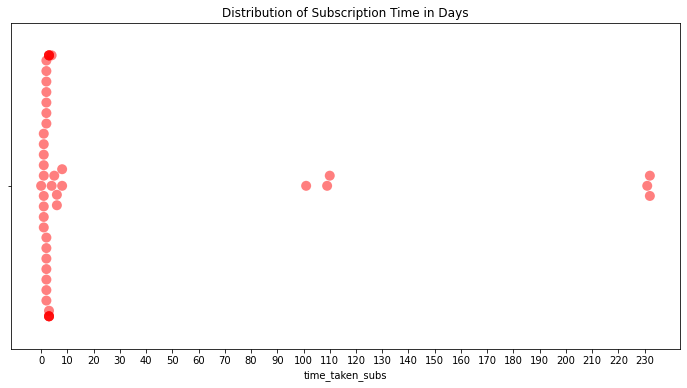

In [ ]:
# Creating swarmplot to see the distribution of Subscription time in days
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
ax = sns.swarmplot(x=time_mer1['time_taken_subs'],alpha=0.5,color='red',size=10)
ax1=plt.xticks(np.arange(0,240,10))
ax2=plt.title('Distribution of Subscription Time in Days')

The above swarmplot denotes that most of the students subscribed **within 10-15** days to subscribe while few took a very long time.

# Sales conversion with respect to Source (Field available in Interested Users)

In [ ]:
# getting all interested+demo class registered students as before
mer=pd.merge(interest[['Child Name','source']],book[['Child Name','Attendance']],on=['Child Name'],how='inner')
mer.head()

,Child Name,source,Attendance
0,CH_30004,lastchance,Attended
1,CH_30005,lastchance,Not Attended
2,CH_30006,lastchance,Not Attended
3,CH_30009,lastchance,Attended
4,CH_30009,lastchance,Not Attended


In [ ]:
# Considering only those students who attended the demo class
mer=mer.query("Attendance=='Attended'")

In [ ]:
# Drop missing values
mer.dropna(inplace=True)

In [ ]:
# Calculating number of students attending demo class for each source
s1=mer.source.value_counts().reset_index(name='Total Attended/source')
s1.head()

,index,Total Attended/source
0,TEB5SMS,100
1,b1rmsms,89
2,rfmsms,86
3,TEB3SMS,71
4,TEB11SMS,64


In [ ]:
# Getting number of students who attended demo class also subscribed
mer_s=pd.merge(mer[['Child Name','source']],sub[['Child Name']],on=['Child Name'],how='inner')

In [ ]:
# Calculating no. of subscribed students in each source
s2=mer_s.source.value_counts().reset_index(name='No. Converted')
s2.head()

,index,No. Converted
0,rfmsms,12
1,b1rmsms,10
2,TEB5SMS,9
3,TEB11SMS,6
4,ntfpush,5


In [ ]:
# Calculating sales conversion for source
s_m=pd.merge(s1,s2,on='index',how='inner')
s_m['Conversion Rate Source']=round(((s_m['No. Converted']/s_m['Total Attended/source'])*100),2)

In [ ]:
s_m.rename(columns={'index':'source'},inplace=True)

In [ ]:
s_m

,source,Total Attended/source,No. Converted,Conversion Rate Source
0,TEB5SMS,100,9,9.00
1,b1rmsms,89,10,11.24
2,rfmsms,86,12,13.95
3,TEB3SMS,71,1,1.41
4,TEB11SMS,64,6,9.38
5,b2rmsms,48,3,6.25
6,TEB4SMS,45,4,8.89
7,ntfuiuser,44,3,6.82
8,TEB12SMS,44,3,6.82
9,T1KRMSMS,34,4,11.76


In [ ]:
# Showing the table in neat format
fig = go.Figure(data=[go.Table(
    header=dict(values=list(s_m.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[s_m['source'],s_m['Total Attended/source'],s_m['No. Converted'],s_m['Conversion Rate Source']],
               fill_color='lavender',
               align='left'))
])

fig.show()

Feature Description:

**source:** name of source

**Total Attended/source:** Total students who attended the demo class in each source

**No. Converted:** Total students who attended the demo class bought a subscription

**Conversion Rate Source:** Sales Conversion in each source.

One thing to note in the above table that in '**adarsh**' source total student attended the demo is 1 but out of them 2 subscribed. **This sounds impossible !!!** Let's see what's going on.

In [ ]:
book[book['Child Name']=='CH_31293']

,Invitee UUID,Batch,Enrolment Type,Child Name,Grade,School,Phone,Parent Email,Opted Start Time,Opted Start Date,Facilitator UUID,Attendance
1440,AHPX76FLYHAEQMS3,"fREADom Trial - Grades 3, 4 [I] 04:00pm - Sat...",Trial,CH_31293,Grade 4,Manav Rachna international school,911100222288,s2m_test_21301@tests2m.com,25-04-2020 16:00:00,"04:00pm - Saturday, April 25, 2020",CDBCIBX6WD5NGCEZ,Attended


In [ ]:
sub[sub['Child Name']=='CH_31293']

,Child Name,Registered Number,Registered Email ID,Payment date,Sale by,Grade,Pricing,Duration,Sessions preferred,Live session details
218,CH_31293,9.111002e+11,NaN,2020-08-04 21:28:09,SP_1001,1,1999,12G + 1 yr,SCJ/13042020/Batch 3,Live - Upsell (Larger plan)
387,CH_31293,9.111002e+11,s2m_test_21301@tests2m.com,25-04-2020 9:44:44 PM,SP_1001,NaN,1999,10 G + 1 Year,Assigned,NaN




```
# This is formatted as code
```

The above two cells solve the ambiguity. The concerned student enrolled for one demo class but he then made two subscriptions. So here one student making two subscriptions.

So the Sales Conversion is indeed double from a single source '**adarsh**' so the Conversion Rate can be rigtly considered to  be **200%**.

In [ ]:
# Average sales conversion of all source

(s_m['No. Converted'].sum()/s_m['Total Attended/source'].sum())*100

9.806835066864785

Average sales conversion across all source is **9.81%.**

In [ ]:
# Plotting Sales Conversion in each source
fig = go.Figure(go.Bar(
            x=s_m['Conversion Rate Source'],
            y=s_m['source'],
            orientation='h',marker=dict(color='pink',line=dict(color='deeppink',width=2))))


fig.update_layout(template='plotly_white',title='Sales Conversion % in Source',xaxis_title='% Sales Conversion',yaxis_title='Source')

fig.show()

Leaving the '**adarsh**' source(*discussed above*),'**nlusms**' has the highest sales conversion(***28.57***) followed by '**lastchance**' and then others. **3** have above **20 %** conversion rate, **4** had above **15%** and **7** has above **10%** conversion rate.

Note in the booked user data there were many other sources, but the students of those sources did not subscribe ultimately so their Sales Conversion is 0.